In [49]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData, UVFlag
from tqdm.notebook import tqdm
# There's something I learned about Path objects ...
from glob import glob
from pathlib import Path
import os
plt.rcParams['figure.figsize'] = [10,4]

In [2]:
path = Path('/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/LSTSlice/')
JDs = [str(jd) for jd in np.arange(2457548, 2457555)]

In [3]:
flags_all = {}
for JD in JDs:
    print(JD)
    flagfiles = list(np.sort(glob(os.path.join(path,JD,'*.flh5'))))
    flags_all[JD] = UVFlag(flagfiles)

2457548
2457549
2457550
2457551
2457552
2457553
2457554


In [5]:
# Calculate the AND over all days
or_flags = np.zeros_like(flags_all[JD].flag_array.squeeze())
for JD in JDs:
    or_flags = np.logical_or(or_flags, flags_all[JD].flag_array.squeeze())

In [6]:
# Make the flags for the "other" days in the same 
flags_other = {}

for JD in tqdm(JDs):
    JDs_butone = JDs.copy()
    JDs_butone.remove(JD)
    NJDs = len(JDs_butone)
    
    cnts = np.zeros_like(flags_all[JD].flag_array.squeeze(),dtype='int64')
    for other_JD in JDs_butone:
        # Sum up where the flags are True
        cnts += np.array(flags_all[other_JD].flag_array.squeeze(),dtype='int64')
    
    flags_other[JD] = np.logical_or(flags_all[JD].flag_array.squeeze(), cnts > NJDs/2.)

2457548         0.873
2457549         0.864
2457550         0.843
2457551         0.855
2457552         0.870
2457553         0.857
2457554         0.861
ALL             0.565
2457548         0.863
2457549         0.856
2457550         0.833
2457551         0.845
2457552         0.860
2457553         0.848
2457554         0.852


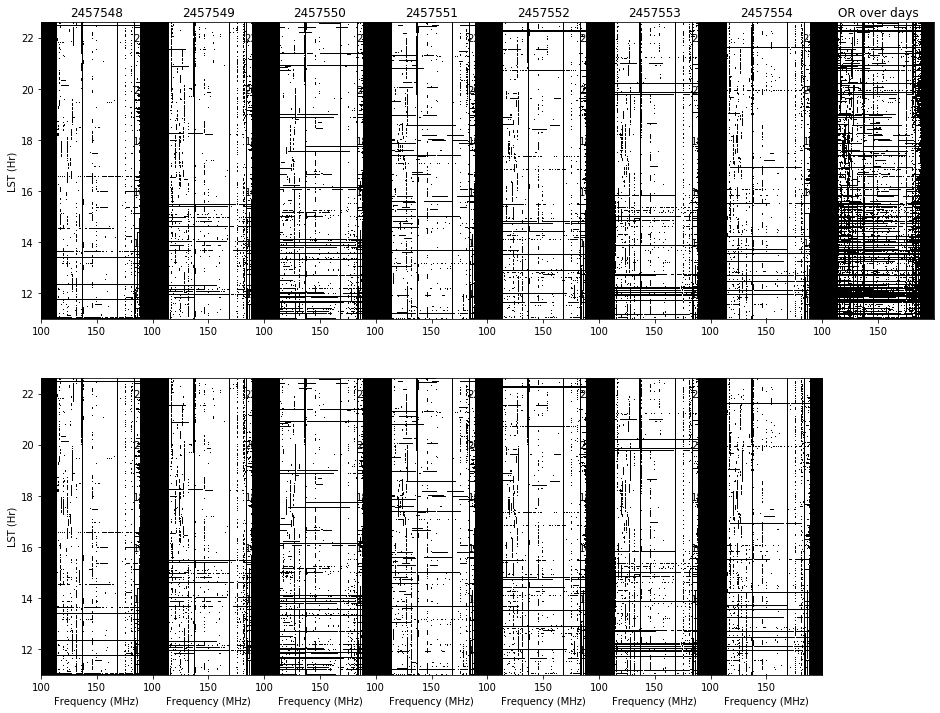

In [21]:
#fig, ax = plt.subplots(nrows=2, ncols=7, 
#                           sharex = 'all', sharey = 'all', 
#                           figsize=(11.5,9)) 

plt.figure(figsize=(16,12))
for ii, JD in enumerate(JDs):
    xx,yy = int(ii/2),ii%2
                       
    flags= ~flags_all[JD].flag_array.squeeze()
    freqs = flags_all[JD].freq_array/1e6
    lsts = flags_all[JD].lst_array*24./(2.*np.pi)
    
    print('{:10s} {:10.3f}'.format(JD, flags[:,150:900].sum()/flags[:,150:900].size))
    
    plt.subplot(2,8,ii+1)
    plt.imshow(flags,aspect='auto', cmap='gray',
               interpolation='none', origin='lower',
               extent=[freqs.min(), freqs.max(), lsts.min(), lsts.max()])
    plt.title(JD)
    
    if ii == 0:
        plt.ylabel('LST (Hr)')


plt.subplot(2,8,8)
plt.title('OR over days')
plt.imshow(~or_flags,aspect='auto', cmap='gray',
           interpolation='none', origin='lower',
           extent=[freqs.min(), freqs.max(), lsts.min(), lsts.max()])

print('{:10s} {:10.3f}'.format('ALL', (~or_flags[:,150:900]).sum()/or_flags[:,150:900].size))

    #im = ax[xx].imshow(flags,aspect='auto', cmap='gray',
    #                      interpolation='none', origin='lower',
    #                      extent=[freqs.min(), freqs.max(), lsts.min(), lsts.max()])
    
for ii, JD in enumerate(JDs):
    xx,yy = int(ii/2),ii%2
                       
    flags= ~flags_other[JD]
    freqs = flags_all[JD].freq_array/1e6
    lsts = flags_all[JD].lst_array*24./(2.*np.pi)
    
    
    plt.subplot(2,8,ii+1+8)
    plt.imshow(flags,aspect='auto', cmap='gray',
               interpolation='none', origin='lower',
               extent=[freqs.min(), freqs.max(), lsts.min(), lsts.max()])
    #plt.title(JD)

    plt.xlabel('Frequency (MHz)')
    if ii == 0:
        plt.ylabel('LST (Hr)')
    print('{:10s} {:10.3f}'.format(JD, flags[:,150:900].sum()/flags[:,150:900].size))

plt.subplots_adjust(wspace=0)

The things that are being flagged below 137 MHz which wander in frequency is almost certinaly _not_ RFI, but some sort of strong astrophysical signal which is deemed above threshold.

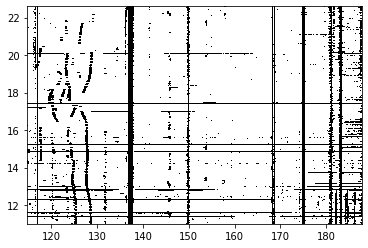

In [17]:
#fig.subplots_adjust(wspace=0)
plt.imshow((~flags_all[JDs[6]].flag_array.squeeze())[:,150:900], aspect='auto', cmap='gray',
           interpolation='none', origin='lower',
           extent=[freqs[150:900].min(), freqs[150:900].max(), lsts.min(), lsts.max()])

In [72]:
flags_per_day = np.zeros_like(np.array(flags_all[JDs[0]].flag_array.squeeze(),dtype='float64')[:,150:900])
for JD in JDs:
    flags = np.array(flags_all[JD].flag_array.squeeze(),dtype='float64')[:,150:900]
    flags_per_day += flags
lst_per_day = lsts
freq_per_day = freqs[150:900]

<IPython.core.display.Javascript object>


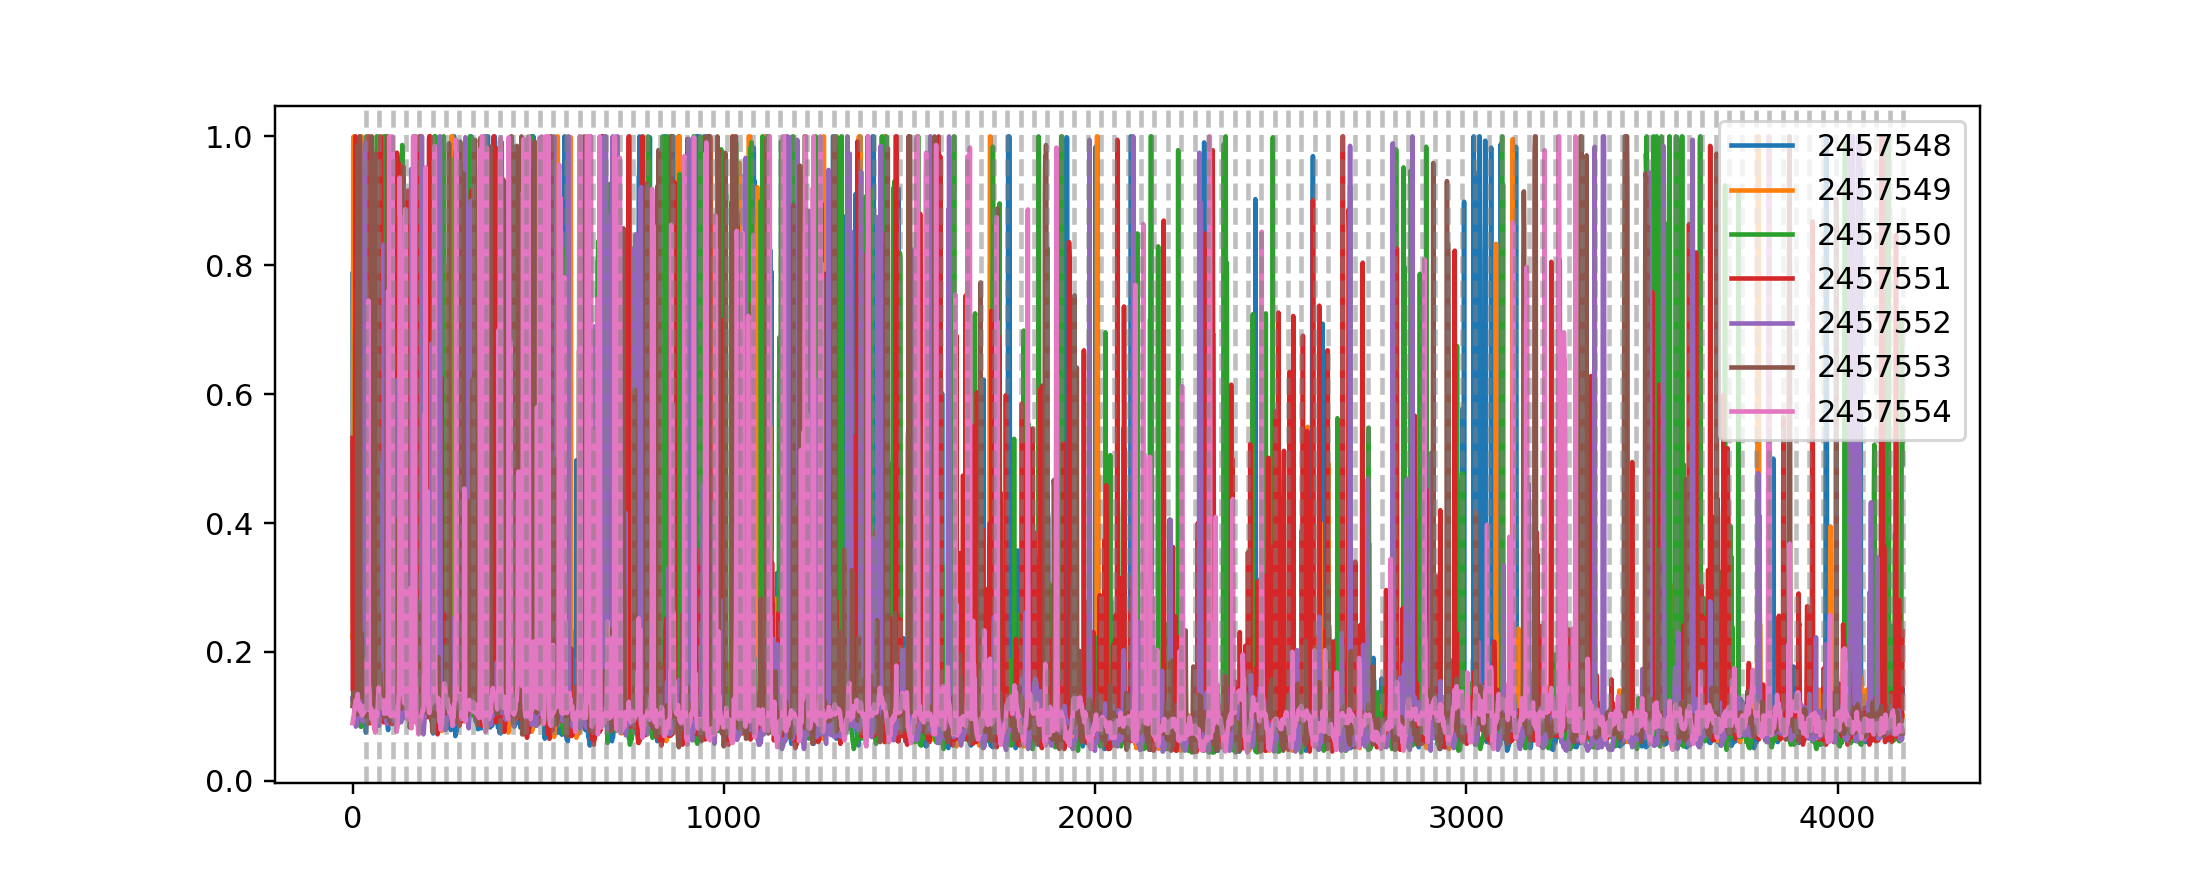

In [73]:
%matplotlib notebook
plt.figure()

for JD in JDs:
    flags = np.array(flags_all[JD].flag_array.squeeze(),dtype='float64')[:,150:900]
    plt.plot(flags.mean(axis=1), label=JD)
    
plt.legend()
#plt.ylim([0,0.2])

for i in np.arange(1,117):
    plt.axvline(i*36, color='gray', linestyle='--', alpha=0.5)

There's a periodicity in the baseline number of flags as a function of LST that's pretty suspicious.

<IPython.core.display.Javascript object>


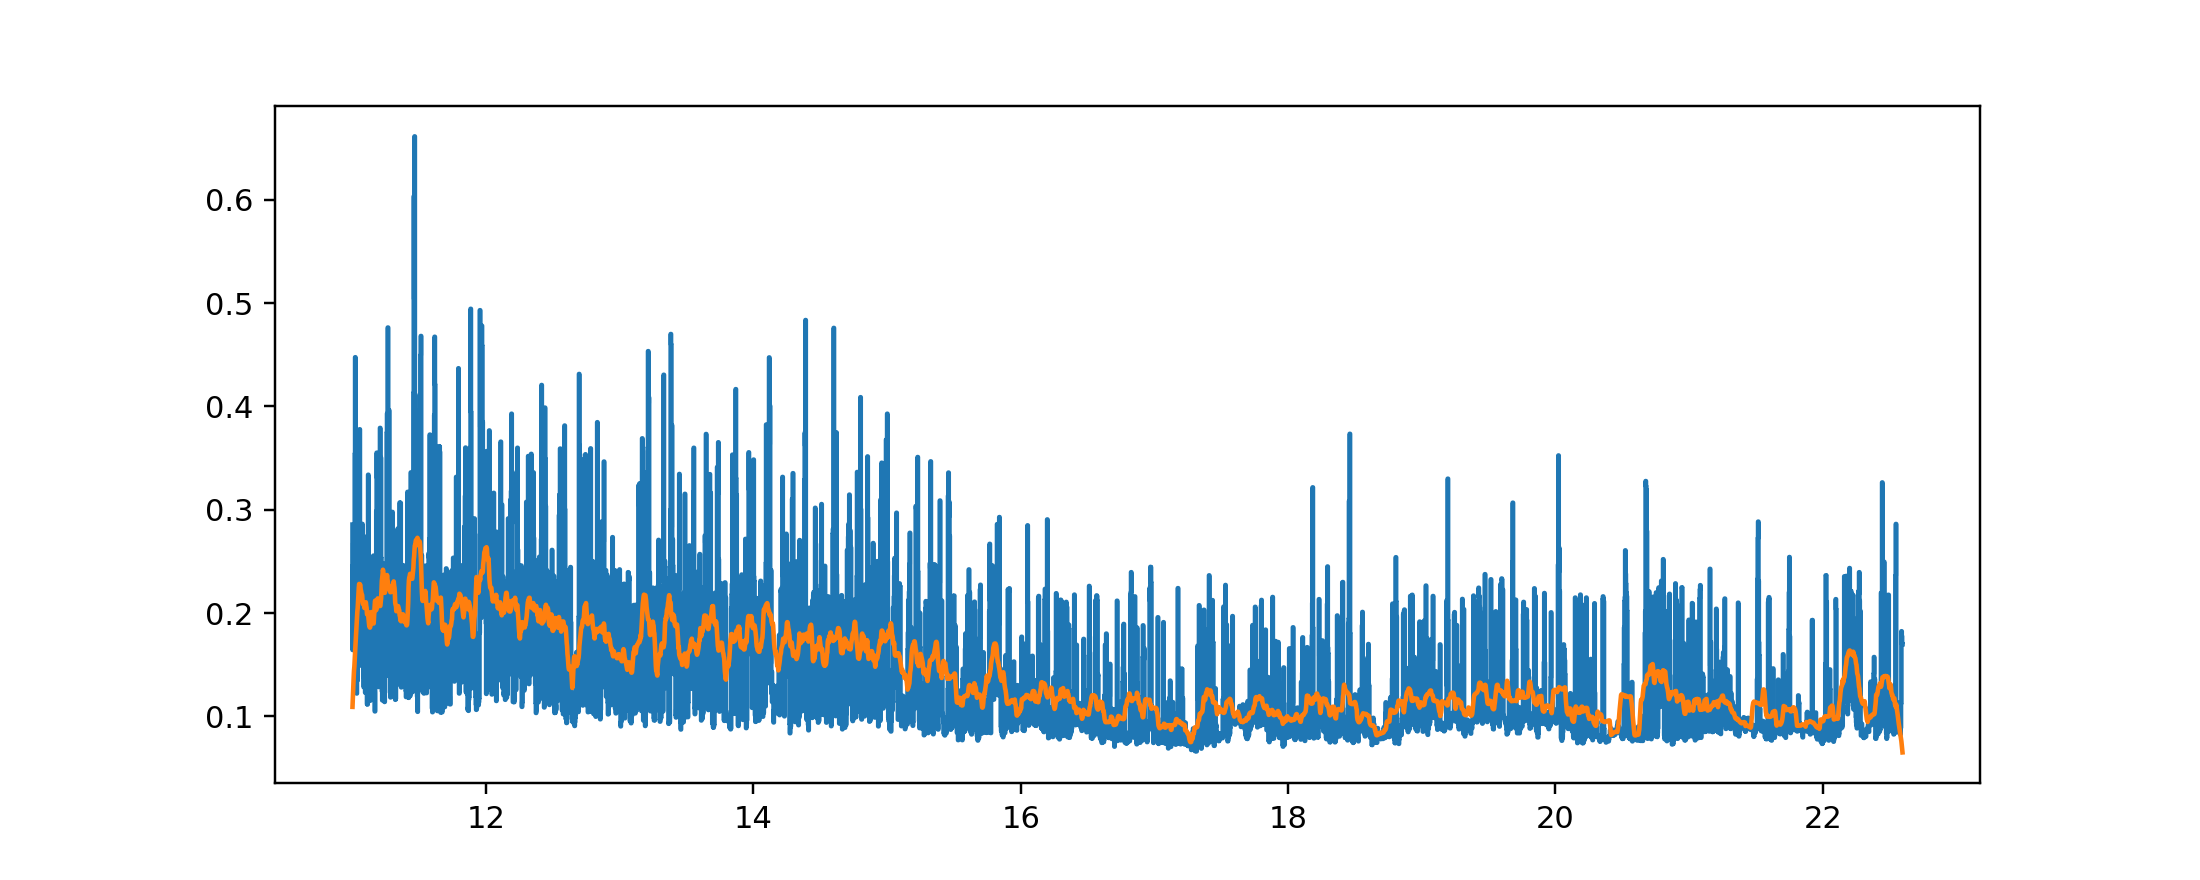

In [82]:
mean_flags_per_lst = flags_per_day.mean(axis=1)/7.

plt.figure()
plt.plot(lsts, mean_flags_per_lst, drawstyle='steps')

window = np.ones(36)/36.
mean_flags_per_lst_smooth = np.convolve(mean_flags_per_lst,window, mode='same')

plt.plot(lsts, mean_flags_per_lst_smooth)
#plt.set_drawstyle('steps')

<IPython.core.display.Javascript object>


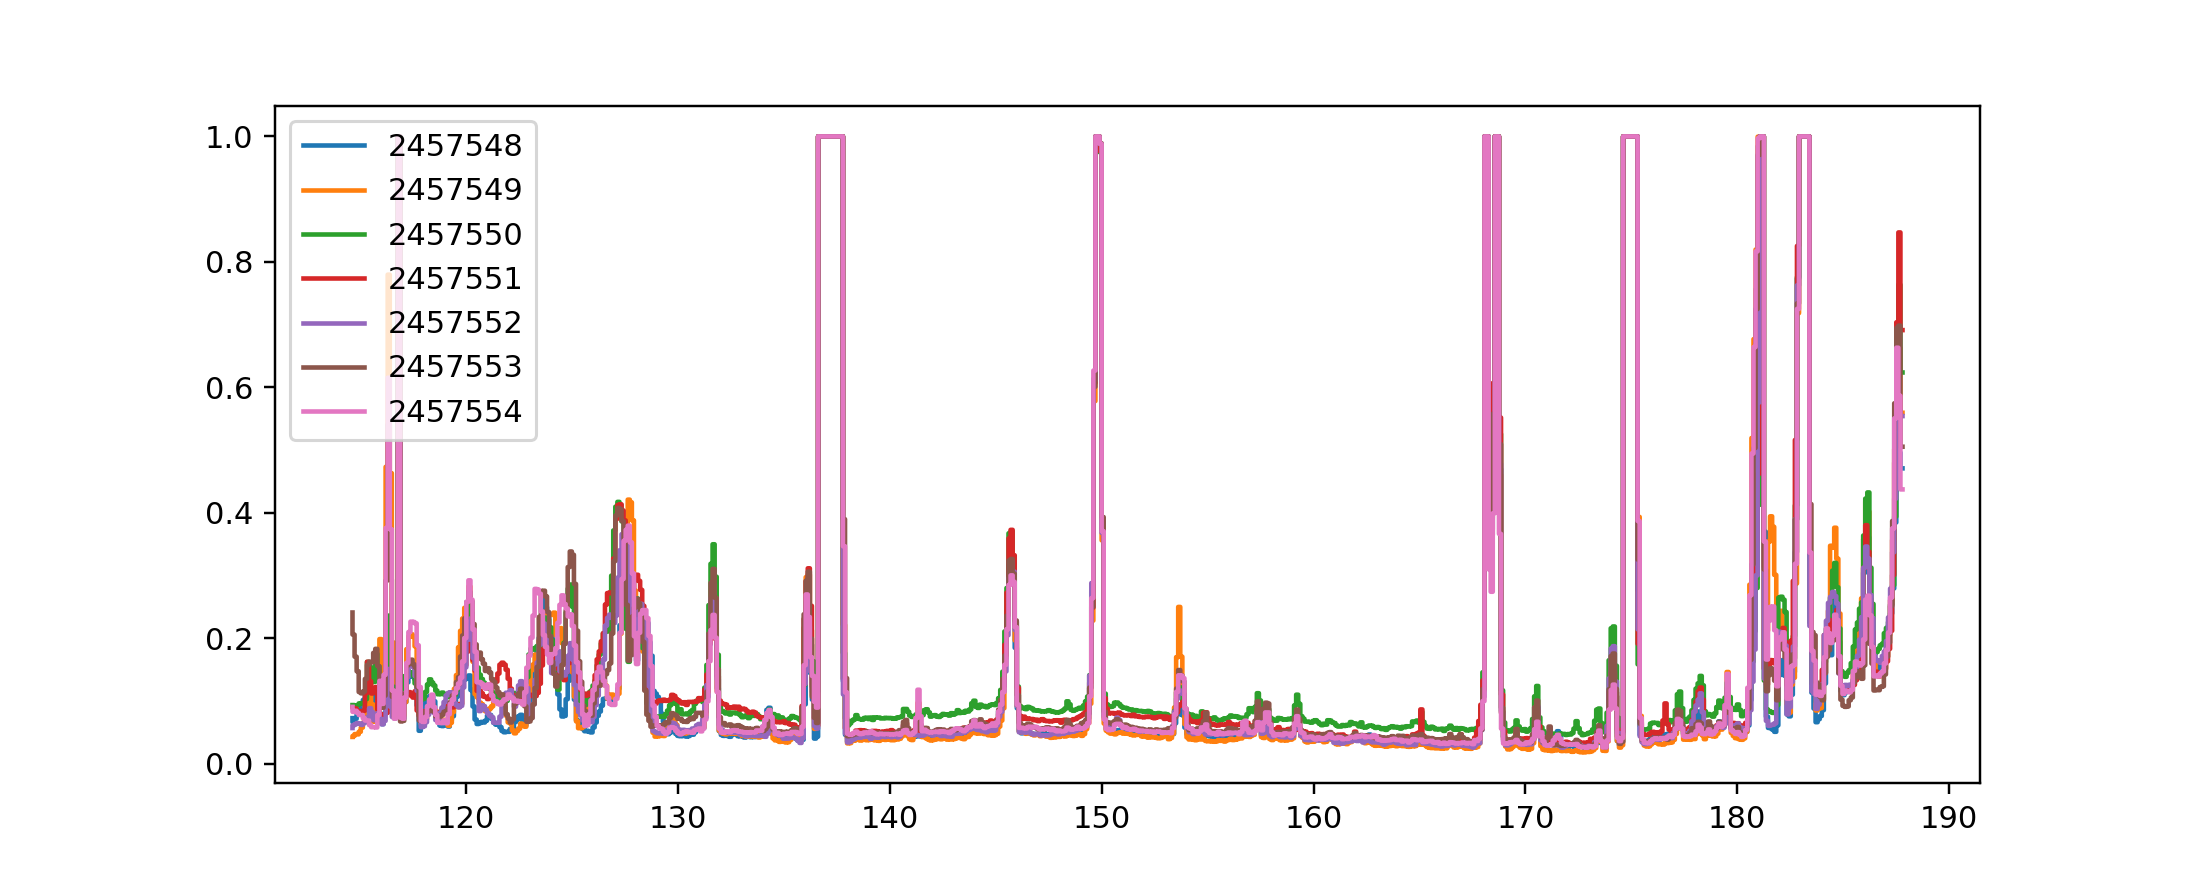

In [79]:
plt.figure()

for JD in JDs:
    flags = np.array(flags_all[JD].flag_array.squeeze(),dtype='float64')[:,150:900]
    plt.plot(freq_per_day, flags.mean(axis=0), label=JD, drawstyle='steps')
    
plt.legend()

<IPython.core.display.Javascript object>


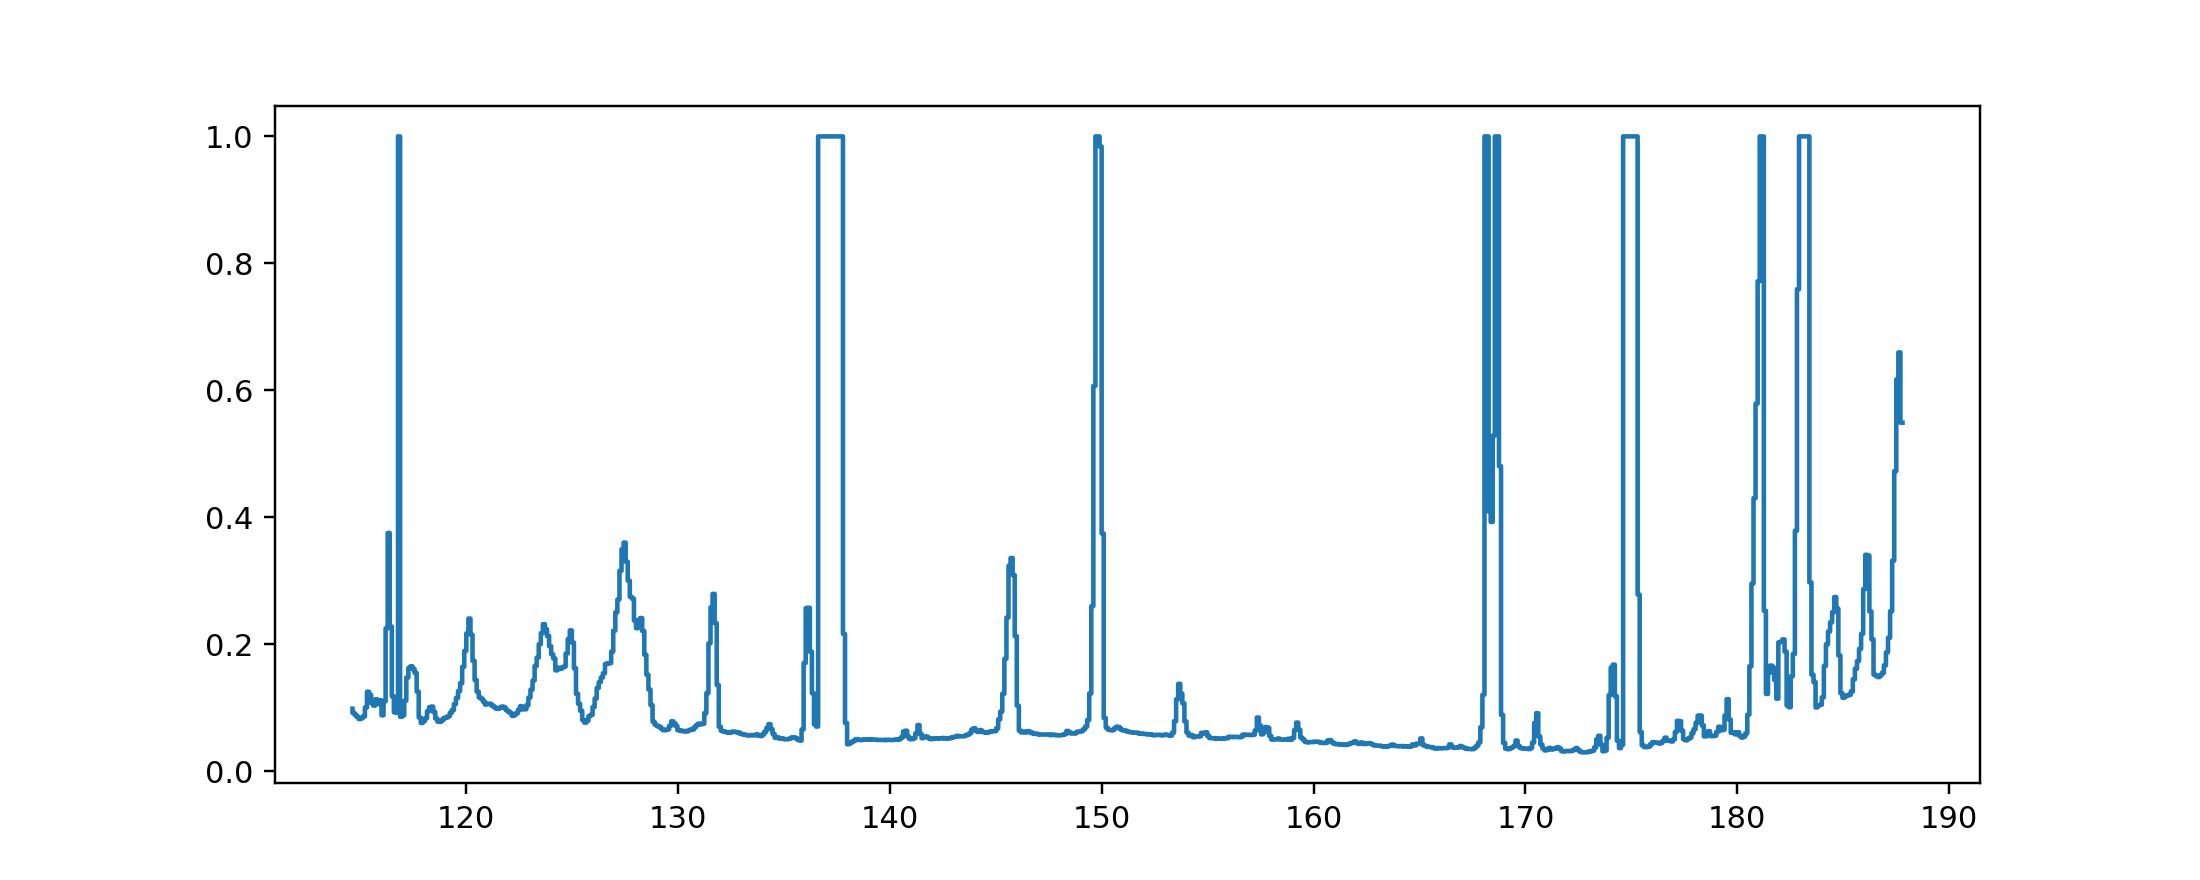

In [81]:
mean_flags_per_freq = flags_per_day.mean(axis=0)/7.

plt.figure()
plt.plot(freq_per_day, mean_flags_per_freq, drawstyle='steps')